<a href="https://colab.research.google.com/github/Oleksij-gh/infotech-task/blob/main/infotech_test_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Libs

In [1]:
import copy
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

# 2. Loading Data

In [2]:
!gdown #link to data

Downloading...
From: https://drive.google.com/uc?id=1FYaj-YQn7WADkCflz8-4Q89G9Aj8XxOi
To: /content/schedule_dataset.xlsx
100% 8.31M/8.31M [00:00<00:00, 64.7MB/s]


In [3]:
df_origin = pd.read_excel('/content/schedule_dataset.xlsx')

In [4]:
df_origin.head()

,Дата рейса,Рейс,А/П отправл,А/П прибыт,Номер ВС,Время отправления по расписанию,Время отправления фактическое,Время прибытия по расписанию,Время прибытия фактическое
0,2018-03-01,1,MOW,ARH,1,2018-03-01 00:05:00,2018-02-28 23:48:00,2018-03-01 02:00:00,2018-03-01 01:48:00
1,2018-03-01,2,MOW,EGO,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00
2,2018-03-01,3,MOW,AKX,3,2018-03-01 00:15:00,2018-03-01 00:14:00,2018-03-01 02:40:00,2018-03-01 02:32:00
3,2018-03-01,4,LED,MOW,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00
4,2018-03-01,5,MOW,KRR,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00


После считывания датасета столбцы с временем неправильно преобразовались

# Визуальный анализ

In [5]:
df = df_origin.copy()

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns

Переименование столбцов

In [7]:
df  = df.rename(columns={'Дата рейса': 'flight_date',
                   'Рейс': 'flight',
                   'А/П отправл': 'airport_out',
                   'А/П прибыт': 'airport_in',
                   'Номер ВС': 'air_number',
                   'Время отправления по расписанию': 'scheduled_time_out',
                   'Время отправления фактическое': 'actual_time_out',
                   'Время прибытия по расписанию': 'scheduled_time_in',
                   'Время прибытия фактическое': 'actual_time_in'})

In [8]:
df.head()

,flight_date,flight,airport_out,airport_in,air_number,scheduled_time_out,actual_time_out,scheduled_time_in,actual_time_in
0,2018-03-01,1,MOW,ARH,1,2018-03-01 00:05:00,2018-02-28 23:48:00,2018-03-01 02:00:00,2018-03-01 01:48:00
1,2018-03-01,2,MOW,EGO,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00
2,2018-03-01,3,MOW,AKX,3,2018-03-01 00:15:00,2018-03-01 00:14:00,2018-03-01 02:40:00,2018-03-01 02:32:00
3,2018-03-01,4,LED,MOW,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00
4,2018-03-01,5,MOW,KRR,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00


In [9]:
df.head()

,flight_date,flight,airport_out,airport_in,air_number,scheduled_time_out,actual_time_out,scheduled_time_in,actual_time_in
0,2018-03-01,1,MOW,ARH,1,2018-03-01 00:05:00,2018-02-28 23:48:00,2018-03-01 02:00:00,2018-03-01 01:48:00
1,2018-03-01,2,MOW,EGO,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00
2,2018-03-01,3,MOW,AKX,3,2018-03-01 00:15:00,2018-03-01 00:14:00,2018-03-01 02:40:00,2018-03-01 02:32:00
3,2018-03-01,4,LED,MOW,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00
4,2018-03-01,5,MOW,KRR,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00


Извлечение дня и месяца полёта в отдельные признаки

In [10]:
df['flight_month'] = df.apply(lambda x: x['flight_date'].month, axis=1)
df['flight_day'] = df.apply(lambda x: x['flight_date'].day, axis=1)
df['day_of_week'] = df.apply(lambda x: x['flight_date'].day_name(), axis=1)

Извлечение времени взлёта\посадки в отдельный признак

In [11]:
df['hour_out'] = df.apply(lambda x: (x['scheduled_time_out'].hour), axis=1)
df['hour_in'] = df.apply(lambda x: (x['scheduled_time_in'].hour), axis=1)
df['minute_out'] = df.apply(lambda x: (x['scheduled_time_out'].minute), axis=1)
df['minute_in'] = df.apply(lambda x: (x['scheduled_time_in'].minute), axis=1)

Получение таргетных переменных

In [12]:
def get_delay_class(scheduled_time, actual_time):
    sec = (actual_time - scheduled_time).total_seconds()

    if sec == 0:
      return 'on_schedule'
    elif sec > 0:
      return 'delay'
    else:
      return 'hurry'

df['target_in'] = df.apply(lambda x: get_delay_class(x['scheduled_time_in'], x['actual_time_in']), axis=1)
df['target_in_sec'] = df.apply(lambda x: (x['actual_time_in'] - x['scheduled_time_in']).total_seconds(), axis=1)
df['target_out'] = df.apply(lambda x: get_delay_class(x['scheduled_time_out'], x['actual_time_out']), axis=1)
df['target_out_sec'] = df.apply(lambda x: (x['actual_time_out'] - x['scheduled_time_out']).total_seconds(), axis=1)

In [13]:
df.head()

,flight_date,flight,airport_out,airport_in,air_number,scheduled_time_out,actual_time_out,scheduled_time_in,actual_time_in,flight_month,flight_day,day_of_week,hour_out,hour_in,minute_out,minute_in,target_in,target_in_sec,target_out,target_out_sec
0,2018-03-01,1,MOW,ARH,1,2018-03-01 00:05:00,2018-02-28 23:48:00,2018-03-01 02:00:00,2018-03-01 01:48:00,3,1,Thursday,0,2,5,0,hurry,-720.0,hurry,-1020.0
1,2018-03-01,2,MOW,EGO,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00,3,1,Thursday,0,1,5,30,delay,1500.0,hurry,-300.0
2,2018-03-01,3,MOW,AKX,3,2018-03-01 00:15:00,2018-03-01 00:14:00,2018-03-01 02:40:00,2018-03-01 02:32:00,3,1,Thursday,0,2,15,40,hurry,-480.0,hurry,-60.0
3,2018-03-01,4,LED,MOW,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00,3,1,Thursday,0,1,20,35,delay,240.0,hurry,-540.0
4,2018-03-01,5,MOW,KRR,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00,3,1,Thursday,0,2,25,40,delay,60.0,hurry,-240.0


Гистограмма для посадки


<Axes: >

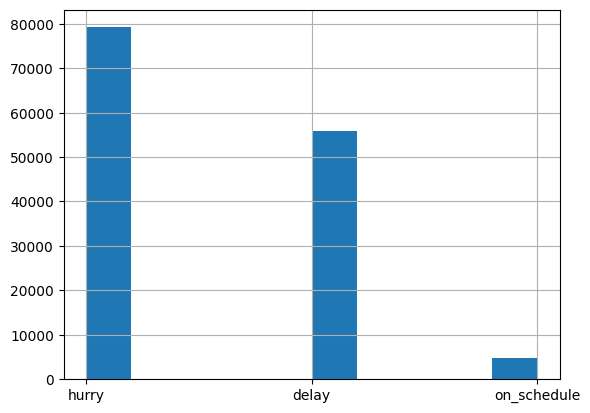

In [14]:
df['target_in'].hist()

Явный дизбаланс классов

Гистограмма для взлёта

<Axes: >

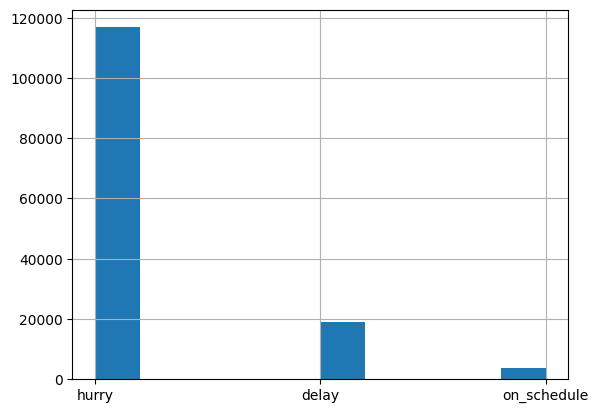

In [15]:
df['target_out'].hist()

Явный дизбаланс классов

Матрица корреляций

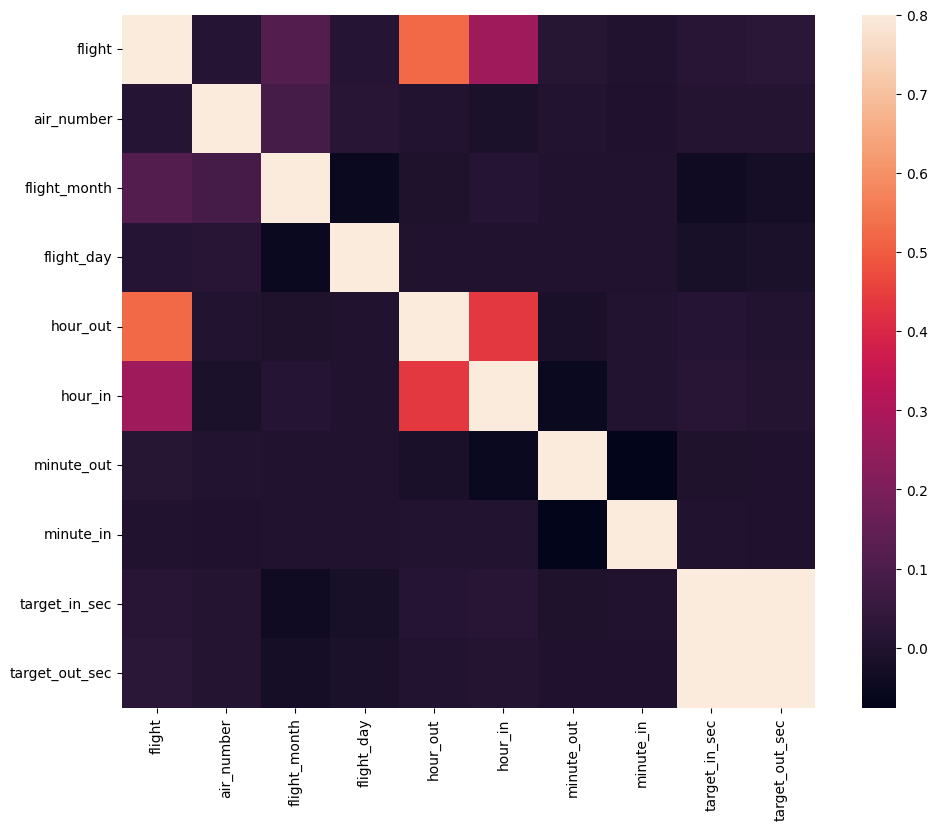

In [16]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
corrmat = df[numeric_columns].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

Наблюдается логичная небольшая корреляция у следующих параметров:
- время взлёта \ время посадки
- номер рейса \ время взлёта
- номер рейса \ время посадки

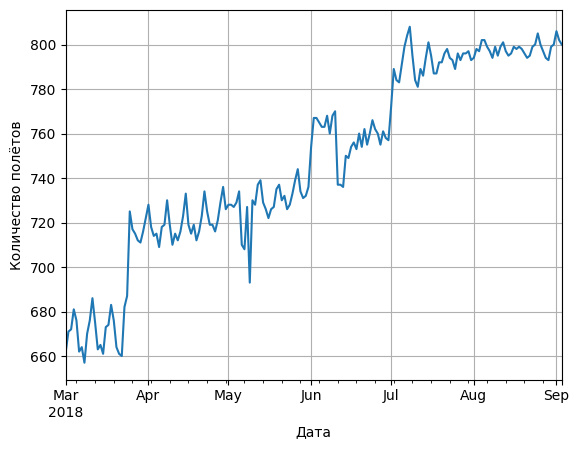

In [17]:
df.groupby('flight_date')['target_in'].count().plot()
plt.xlabel('Дата')
plt.ylabel('Количество полётов')
plt.grid()
plt.show()

На графике можно ответить:
- сезонность
- рост
- аномальный спад в период Май-Июнь

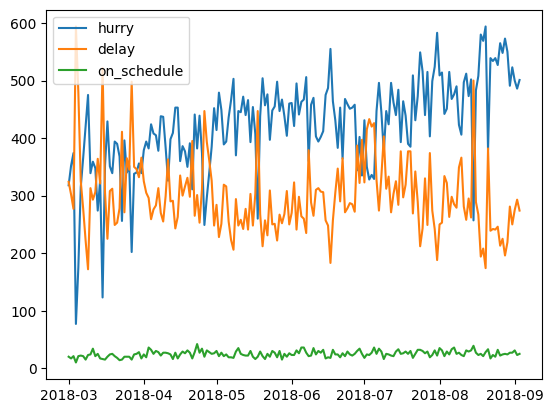

In [18]:
legend = []
for v in df['target_in'].unique():
   diseases = df[df['target_in']==v].groupby('flight_date')['target_in'].count()
   x = diseases.index
   y = diseases.values
   plt.plot(x, y)
   legend.append(v)
plt.legend(legend)
plt.show()

Видно, что количество рейсов вылетевших **раньше** обратно пропорционально количеству **задержанных**.

Зависимости с количеством **вовремя** вылетевших рейсов **не обранужено**

# 3. Предобработка

In [19]:
def preprocess(df):

  # Переименуем столбцы
  df  = df.rename(columns={'Дата рейса': 'flight_date',
                   'Рейс': 'flight',
                   'А/П отправл': 'airport_out',
                   'А/П прибыт': 'airport_in',
                   'Номер ВС': 'air_number',
                   'Время отправления по расписанию': 'scheduled_time_out',
                   'Время отправления фактическое': 'actual_time_out',
                   'Время прибытия по расписанию': 'scheduled_time_in',
                   'Время прибытия фактическое': 'actual_time_in'})

  # Извлечем день и месяц полёта в отдельные признаки и удаляем исходный столбец
  df['flight_month'] = df.apply(lambda x: x['flight_date'].month, axis=1)
  df['flight_day'] = df.apply(lambda x: x['flight_date'].day, axis=1)
  df['day_of_week'] = df.apply(lambda x: x['flight_date'].day_name(), axis=1)
  df = df.drop('flight_date', axis=1)

  # Извлечем время взлёта\посадки в отдельный признак
  df['hour_out'] = df.apply(lambda x: (x['scheduled_time_out'].hour), axis=1)
  df['hour_in'] = df.apply(lambda x: (x['scheduled_time_in'].hour), axis=1)
  df['minute_out'] = df.apply(lambda x: (x['scheduled_time_out'].minute), axis=1)
  df['minute_in'] = df.apply(lambda x: (x['scheduled_time_in'].minute), axis=1)

  # Преобразование времени взлёта\посадки и дня недели к типу object,
  # т.к. это категориальные признаки и в дальнейшем будут преобразованы с помощью endcoder

  df['hour_out'] = df['hour_out'].astype(object)
  df['hour_in'] = df['hour_in'].astype(object)
  df['minute_out'] = df['minute_out'].astype(object)
  df['minute_in'] = df['minute_in'].astype(object)
  df['day_of_week'] = df['day_of_week'].astype(object)

  return df


In [20]:
def get_df_target(df, type_target, binary_classification=True):

  def get_delay_class(scheduled_time, actual_time, binary_classification):
    sec = (actual_time - scheduled_time).total_seconds()

    if sec == 0:
      # on_schedule
      return 0
    elif sec > 0:
      # delay
      return 1
    else:
      if not binary_classification:
        return 2
      # hurry
      return 0


  df['target'] = df.apply(lambda x: get_delay_class(x['scheduled_time_' + type_target], x['actual_time_' + type_target], binary_classification), axis=1)

  df = df.drop(['actual_time_out', 'actual_time_in'], axis=1)

  return df


# 4. Формирование датасета

## One-hot-encoder

In [21]:
from sklearn.preprocessing import OneHotEncoder

In [22]:
def encode(df):
  categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
  encoder = OneHotEncoder(sparse_output=False)
  encoder = encoder.fit(df[categorical_columns])
  ohe = encoder.transform(df[categorical_columns])
  ohe_df = pd.DataFrame(ohe, columns=encoder.get_feature_names_out(categorical_columns))
  df = pd.concat([df, ohe_df], axis=1)
  df = df.drop(categorical_columns, axis=1)
  return df, encoder

## Train Test Val split

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
def split_data(X, y, seed=42):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed)

  return X_train, y_train, X_val, y_val, X_test, y_test

# 5. Models

## Sklearn models

### Fit

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


def train(X_train, y_train):

  models = {}

  # Logistic Regression
  models['Logistic Regression'] = LogisticRegression()

  # Support Vector Machines
  models['Support Vector Machines'] = LinearSVC()

  # Decision Trees
  models['Decision Trees'] = DecisionTreeClassifier()

  # Random Forest
  models['Random Forest'] = RandomForestClassifier()

  # Naive Bayes
  models['Naive Bayes'] = GaussianNB()

  # K-Nearest Neighbors
  models['K-Nearest Neighbor'] = KNeighborsClassifier()

  for key in models.keys():

      # Fit the classifier
      models[key].fit(X_train, y_train)
  return models


### Evaluate

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def evaluate(models, X_val, y_val, pos_label=1):
  accuracy, precision, recall, f1 = {}, {}, {}, {}

  for key in models.keys():

      # Make predictions
      predictions = models[key].predict(X_val)

      # Calculate metrics
      accuracy[key] = accuracy_score(predictions, y_val)
      precision[key] = precision_score(predictions, y_val, pos_label=pos_label)
      recall[key] = recall_score(predictions, y_val, pos_label=pos_label)
      f1[key] = f1_score(predictions, y_val, pos_label=pos_label)

  df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1'])
  df_model['Accuracy'] = accuracy.values()
  df_model['Precision'] = precision.values()
  df_model['Recall'] = recall.values()
  df_model['F1'] = f1.values()

  return df_model


### Plot metrics

In [27]:
def plot_metrics(df_model, models):
  ax = df_model.plot.barh()
  ax.legend(
      ncol=len(models.keys()),
      bbox_to_anchor=(0, 1),
      loc='lower left',
      prop={'size': 14}
  )
  plt.tight_layout()


### Save

In [28]:
import pickle

def save_model(model, model_name='model'):
  with open(model_name+'.pkl','wb') as f:
      pickle.dump(model, f)

# Initialize

Попробуем построить модель для бинарной классификации
- 0 - рейс прибыл вовремя или раньше запланированного
- 1 - рейс опоздал

## Preprocess

In [29]:
df = df_origin.copy()

In [30]:
df = preprocess(df)
df, encoder = encode(df)

In [31]:
save_model(encoder, 'encoder')

In [32]:
!cp /content/encoder.pkl /content/drive/MyDrive/for_download

## Save

## Sklearn models for delay in

In [33]:
df_in = get_df_target(df, 'in')
df_in = df_in.drop(['scheduled_time_out', 'scheduled_time_in'], axis=1)
df_in['target'].value_counts()

target
0    83871
1    55861
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Accuracy,Precision,Recall,F1
Logistic Regression,0.630944,0.277718,0.583240,0.376270
Support Vector Machines,0.608330,0.065970,0.604746,0.118963
Decision Trees,0.603643,0.505445,0.505581,0.505513
Random Forest,0.665045,0.471077,0.605647,0.529952
Naive Bayes,0.633127,0.469023,0.549639,0.506141
K-Nearest Neighbor,0.578738,0.386270,0.469051,0.423655


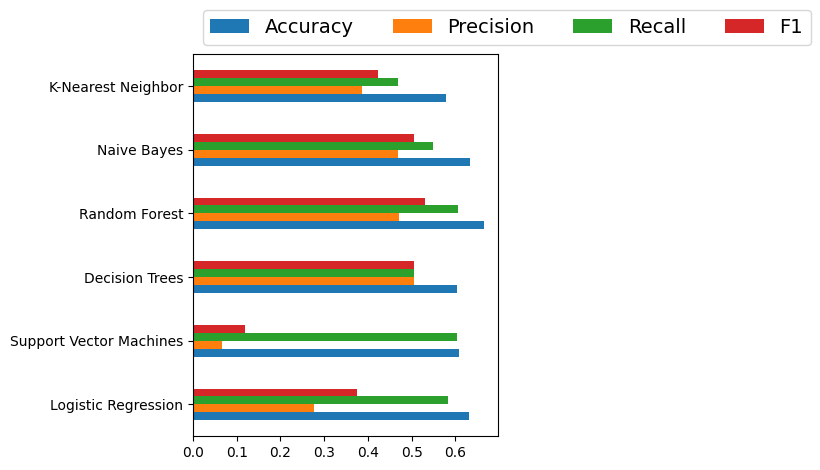

In [34]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_in.drop('target', axis=1).values, df_in['target'].values)
models = train(X_train, y_train)
df_val = evaluate(models, X_val, y_val)
plot_metrics(df_val, models)
df_val

Без указанных гиперпараметров лучшие результаты:
- Decision Trees
- Random Forest
- K-Nearest Neighbor
---
Немного хуже:
- Naive Bayes
---
Т.к. Decision Trees и Random Forest запускались без параметров, то вероятно они переобучились из-за неограниченной глубины деревьев

## Sklearn models delay out

In [35]:
df_out = get_df_target(df, 'out')
df_out = df_out.drop(['scheduled_time_out', 'scheduled_time_in'], axis=1)
df_out['target'].value_counts()

target
0    120600
1     19132
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Accuracy,Precision,Recall,F1
Logistic Regression,0.865173,0.020871,0.842105,0.040733
Support Vector Machines,0.865889,0.026089,0.869565,0.050659
Decision Trees,0.790675,0.285416,0.260166,0.272207
Random Forest,0.861488,0.145317,0.483507,0.223470
Naive Bayes,0.691988,0.582051,0.241529,0.341393
K-Nearest Neighbor,0.851004,0.081398,0.326702,0.130326


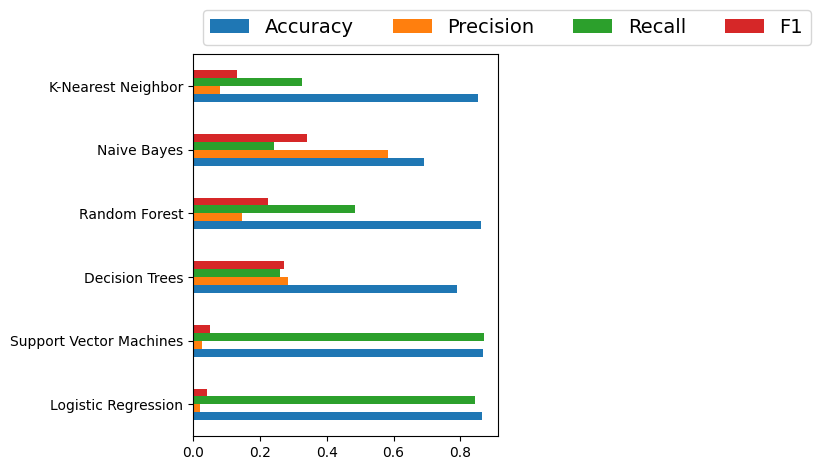

In [36]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df_out.drop('target', axis=1).values, df_out['target'].values)
models = train(X_train, y_train)
df_val = evaluate(models, X_val, y_val)
plot_metrics(df_val, models)
df_val

## Grid Search

# NN

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F



In [38]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [44]:
df_nn = df_out.copy()
X = df_nn.drop('target', axis=1).values
y = df_nn['target'].values

In [45]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

#ros = RandomOverSampler(random_state=42)
#X_train, y_train = ros.fit_resample(X_train, y_train)
#print(sorted(Counter(y_train).items()))

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

In [46]:
class Model(nn.Module):

    def __init__(self, input_shape, output_shape=1):
        super(Model, self).__init__()

        self.fc1 = nn.Linear(input_shape, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=0.2)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, output_shape)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.dropout(x))
        x = F.relu(self.fc5(x))

        return F.sigmoid(self.fc6(x))


In [47]:
learning_rate = 1e-3

model = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

# training parameters
n_epochs = 10   # number of epochs to run
batch_size = 32  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_loss = np.inf   # init to infinity
best_weights = None
history = []
history_val = []

total_params = sum(p.numel() for p in model.parameters())
params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Trainable params count: {params_trainable }')
print(f'Total params count: {total_params}')

Trainable params count: 33569
Total params count: 33569


In [48]:
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            # forward pass
            y_pred = model(X_batch)

            # calculate loss
            loss = criterion(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # print progress
            bar.set_postfix(loss=float(loss))

    history.append(float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    loss_eval = criterion(y_pred, y_test)
    loss_eval = float(loss_eval)
    history_val.append(loss_eval)
    if loss < best_loss:
        best_loss = loss
        best_weights = copy.deepcopy(model.state_dict())

Epoch 9: 100%|██████████| 2620/2620 [00:28<00:00, 91.41batch/s, loss=0.355] 


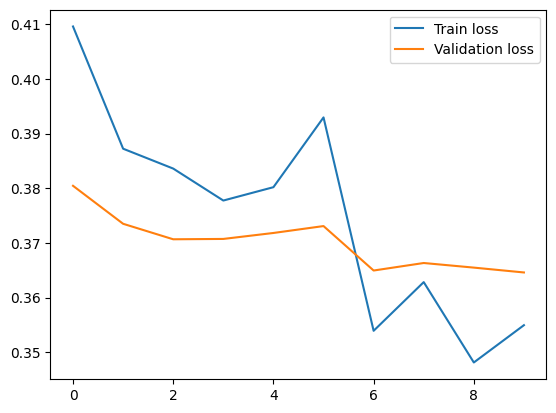

In [49]:
plt.plot(history)
plt.plot(history_val)
plt.legend(['Train loss', 'Validation loss'])

plt.show()

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_nn(models, X_test, y_test, pos_label=1):
  accuracy, precision, recall, f1 = {}, {}, {}, {}

  # Make predictions
  predictions = model(X_test)
  predictions = predictions.detach().numpy().round()
  y_test = y_test.detach().numpy()

  # Calculate metrics
  accuracy = accuracy_score(predictions, y_test)
  precision = precision_score(predictions, y_test)
  recall = recall_score(predictions, y_test)
  f1 = f1_score(predictions, y_test)


  return accuracy, precision, recall, f1

In [52]:
accuracy, precision, recall, f1 = evaluate_nn(model, X_test, y_test)
print(f'Accuracy = {accuracy}')
print(f'Precision = {precision}')
print(f'Recall = {recall}')
print(f'F1 = {f1}')

Accuracy = 0.8658174401545783
Precision = 0.03025560772039645
Recall = 0.7837837837837838
F1 = 0.05826217980914113
